<a href="https://colab.research.google.com/github/ismailsangu/IE423-TASK/blob/main/Task_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Electricity Load Forecasting

### Initialize

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the data

In [3]:

dfELF = pd.read_csv('/content/drive/MyDrive/Data_Sets/continuous dataset.csv')


### Initial Data Check

In [4]:
dfELF.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [5]:
dfELF.shape

(48048, 17)

In [6]:
dfELF.isnull().sum()

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

There is no missed value.

In [7]:
dfELF.duplicated().sum()

0

There is no duplicate.

#Columns

In [8]:
dfELF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    48048 non-null  object 
 1   nat_demand  48048 non-null  float64
 2   T2M_toc     48048 non-null  float64
 3   QV2M_toc    48048 non-null  float64
 4   TQL_toc     48048 non-null  float64
 5   W2M_toc     48048 non-null  float64
 6   T2M_san     48048 non-null  float64
 7   QV2M_san    48048 non-null  float64
 8   TQL_san     48048 non-null  float64
 9   W2M_san     48048 non-null  float64
 10  T2M_dav     48048 non-null  float64
 11  QV2M_dav    48048 non-null  float64
 12  TQL_dav     48048 non-null  float64
 13  W2M_dav     48048 non-null  float64
 14  Holiday_ID  48048 non-null  int64  
 15  holiday     48048 non-null  int64  
 16  school      48048 non-null  int64  
dtypes: float64(13), int64(3), object(1)
memory usage: 6.2+ MB


* nat_demand: National electricity load
* T2M: Temperature at 2 meters
* QV2M: Relative humidity at 2 meters
* TQL: Liquid precipitation
* W2M: Wind speed at 2 meters
And after the underscore is the city

* toc: Tocumen, Panama city
* san: Santiago city
* dav: David city
* The rest of variables:

* Holiday_ID: Unique identification number integer
* holiday: Holiday binary indicator (1=holiday, 0=regular day)
* school: School period binary indicator (1=school, 0=vacations)

### Setting Data Frequency to Hourly

In [9]:
# Convert the index to DatetimeIndex if it's not already
if not isinstance(dfELF.index, pd.DatetimeIndex):
    dfELF['datetime'] = pd.to_datetime(dfELF['datetime'])
    dfELF = dfELF.set_index('datetime')
# Resample the data to ensure an hourly frequency
dfELF = dfELF.resample('H').sum()  #

# set the freq of index column
dfELF.index.freq = 'H'

### Converting Numeric Values to Appropriate Formats

In [10]:
dfELF.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [11]:
# List of columns to convert to numeric
numeric_columns = ['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school']

# Convert each column to numeric
for col in numeric_columns:
    dfELF[col] = pd.to_numeric(dfELF[col], errors='coerce')

In [12]:
dfELF.head(50000)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1


# Exploratory Data Analysis: Visual Overview of Electricity Data

## nat_demand Patterns and Discrepancies

Text(0, 0.5, 'Total Energy(GWh)')

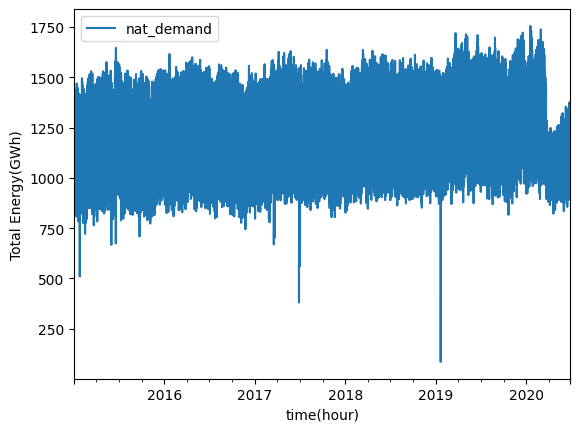

In [13]:
dfELF[['nat_demand']]['2015-01-01': '2020-06-27'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Total Energy(GWh)')

Let's zoom into the data and mark every Saturday by vertical dotted lines.

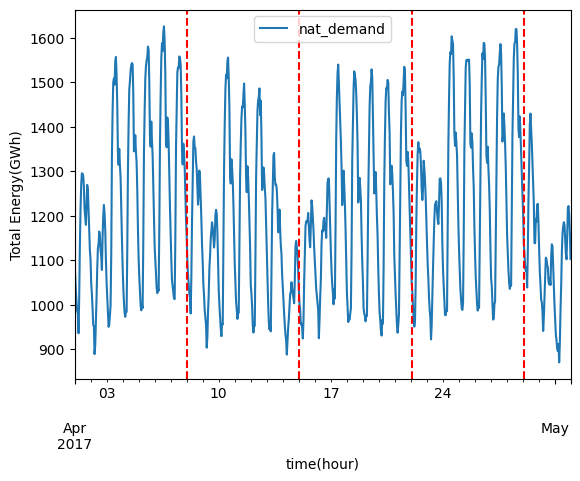

In [14]:

dfELF[['nat_demand']]['2017-04-01': '2017-05-01'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Total Energy(GWh)')

# Adding vertical lines at the start of each week
min_date, max_date = dfELF.index.min(), dfELF.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Saturday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

### Computing Autocorrelation for the 'nat_demand' Column

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

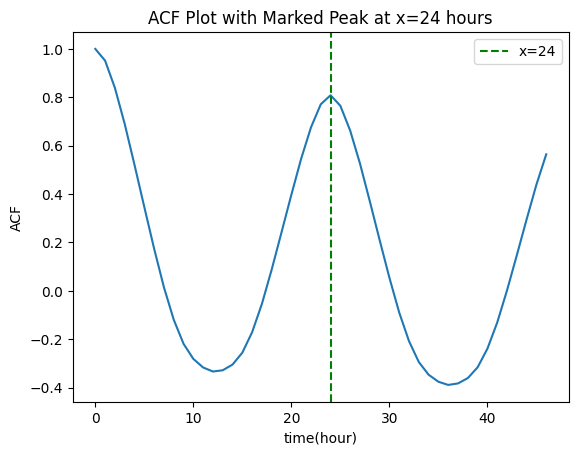

In [15]:

plt.plot(acf(dfELF['nat_demand']))
plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

#City Comparison

In [16]:
dfELF.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

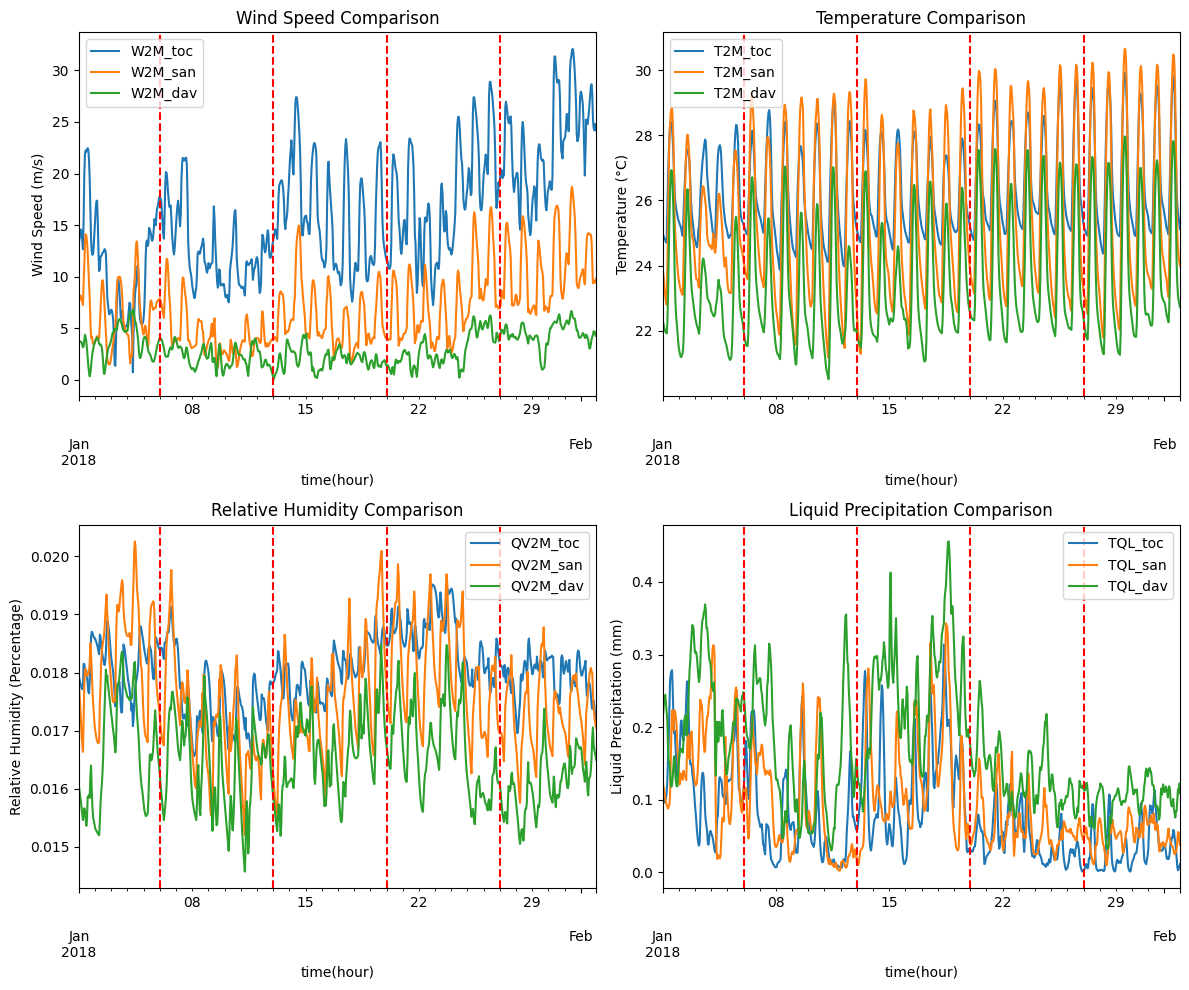

In [17]:
# Create subplots for side-by-side plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Plot Wind Speed
dfELF[['W2M_toc', 'W2M_san', 'W2M_dav']]['2018-01-01': '2018-02-01'].plot(ax=axes[0, 0])
axes[0, 0].set_xlabel('time(hour)')
axes[0, 0].set_ylabel('Wind Speed (m/s)')
axes[0, 0].set_title('Wind Speed Comparison')

# Plot Temperature
dfELF[['T2M_toc', 'T2M_san', 'T2M_dav']]['2018-01-01': '2018-02-01'].plot(ax=axes[0, 1])
axes[0, 1].set_xlabel('time(hour)')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_title('Temperature Comparison')

# Plot Relative Humidity
dfELF[['QV2M_toc', 'QV2M_san', 'QV2M_dav']]['2018-01-01': '2018-02-01'].plot(ax=axes[1, 0])
axes[1, 0].set_xlabel('time(hour)')
axes[1, 0].set_ylabel('Relative Humidity (Percentage)')
axes[1, 0].set_title('Relative Humidity Comparison')

# Plot Liquid Precipitation
dfELF[['TQL_toc', 'TQL_san', 'TQL_dav']]['2018-01-01': '2018-02-01'].plot(ax=axes[1, 1])
axes[1, 1].set_xlabel('time(hour)')
axes[1, 1].set_ylabel('Liquid Precipitation (mm)')
axes[1, 1].set_title('Liquid Precipitation Comparison')

# Adding vertical lines at the start of each week (considering Saturday as the start)
min_date, max_date = pd.to_datetime('2018-01-01'), pd.to_datetime('2018-02-01')
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Saturday
        for ax in axes.flat:  # Iterate over all subplots
            ax.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

### Computing Autocorrelation

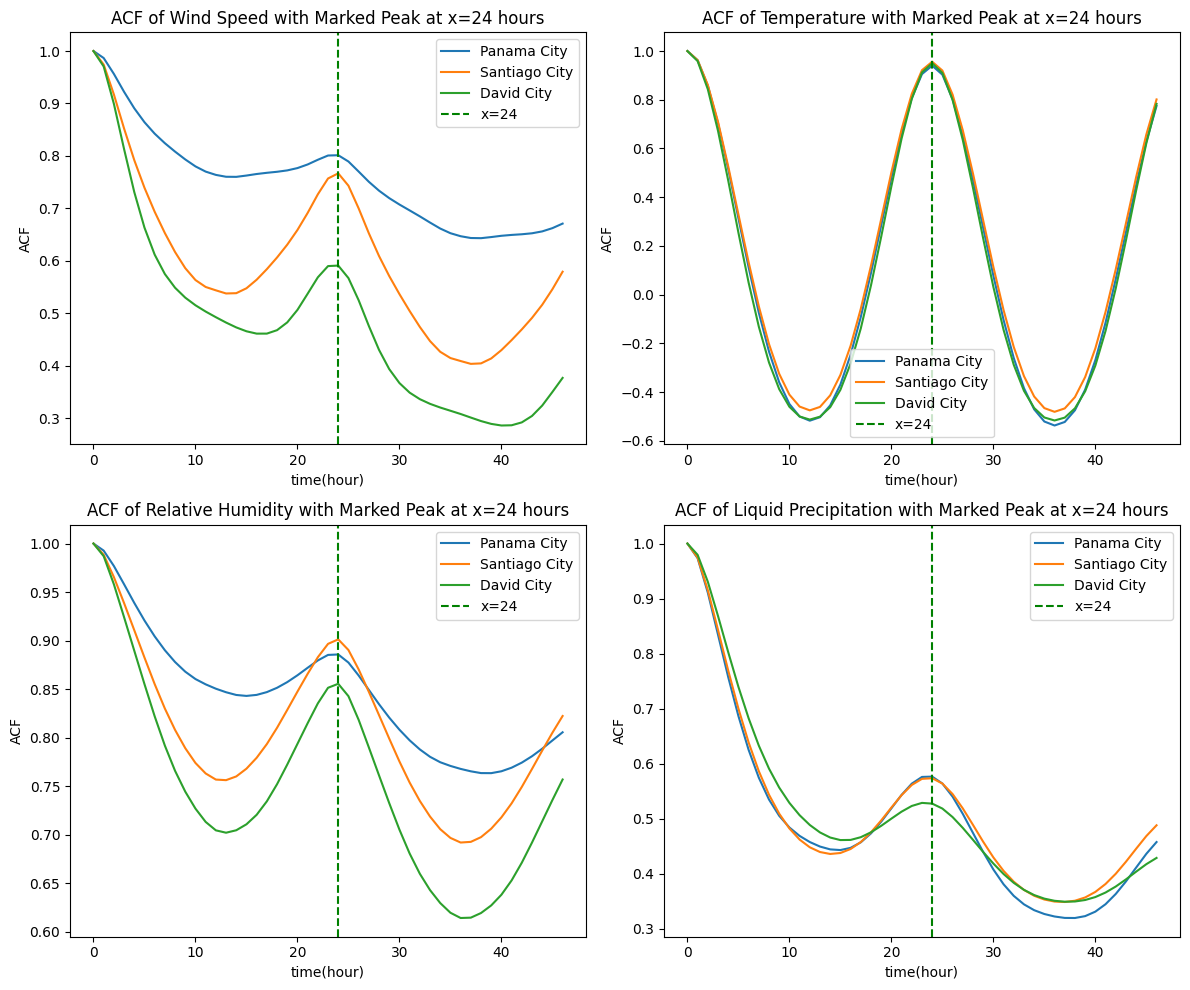

In [18]:
# Create subplots for side-by-side plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# ACF for Wind Speed (W2M)
axes[0, 0].plot(acf(dfELF['W2M_toc']), label='Panama City')
axes[0, 0].plot(acf(dfELF['W2M_san']), label='Santiago City')
axes[0, 0].plot(acf(dfELF['W2M_dav']), label='David City')
axes[0, 0].set_xlabel('time(hour)')
axes[0, 0].set_ylabel('ACF')
axes[0, 0].axvline(x=24, color='green', linestyle='--', label='x=24')
axes[0, 0].legend()
axes[0, 0].set_title('ACF of Wind Speed with Marked Peak at x=24 hours')

# ACF for Temperature (T2M)
axes[0, 1].plot(acf(dfELF['T2M_toc']), label='Panama City')
axes[0, 1].plot(acf(dfELF['T2M_san']), label='Santiago City')
axes[0, 1].plot(acf(dfELF['T2M_dav']), label='David City')
axes[0, 1].set_xlabel('time(hour)')
axes[0, 1].set_ylabel('ACF')
axes[0, 1].axvline(x=24, color='green', linestyle='--', label='x=24')
axes[0, 1].legend()
axes[0, 1].set_title('ACF of Temperature with Marked Peak at x=24 hours')

# ACF for Relative Humidity (QV2M)
axes[1, 0].plot(acf(dfELF['QV2M_toc']), label='Panama City')
axes[1, 0].plot(acf(dfELF['QV2M_san']), label='Santiago City')
axes[1, 0].plot(acf(dfELF['QV2M_dav']), label='David City')
axes[1, 0].set_xlabel('time(hour)')
axes[1, 0].set_ylabel('ACF')
axes[1, 0].axvline(x=24, color='green', linestyle='--', label='x=24')
axes[1, 0].legend()
axes[1, 0].set_title('ACF of Relative Humidity with Marked Peak at x=24 hours')

# ACF for Liquid Precipitation (TQL)
axes[1, 1].plot(acf(dfELF['TQL_toc']), label='Panama City')
axes[1, 1].plot(acf(dfELF['TQL_san']), label='Santiago City')
axes[1, 1].plot(acf(dfELF['TQL_dav']), label='David City')
axes[1, 1].set_xlabel('time(hour)')
axes[1, 1].set_ylabel('ACF')
axes[1, 1].axvline(x=24, color='green', linestyle='--', label='x=24')
axes[1, 1].legend()
axes[1, 1].set_title('ACF of Liquid Precipitation with Marked Peak at x=24 hours')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

As we can see,
* Wind Speed: Variability is highest in Panama City and Santiago City, with David City having the lowest and least variable wind speeds.
* Temperature: All locations exhibit similar diurnal temperature patterns, with minor differences in amplitude.
* Relative Humidity: Santiago City generally has higher relative humidity levels, with all locations showing similar diurnal cycles.
* Liquid Precipitation: Santiago City experiences more frequent and higher precipitation events compared to the other two locations.
* Autocorrelation: All variables exhibit strong daily cycles, with temperature showing the most consistent diurnal pattern across all locations.

## National Electricity Load on Spesific Days:

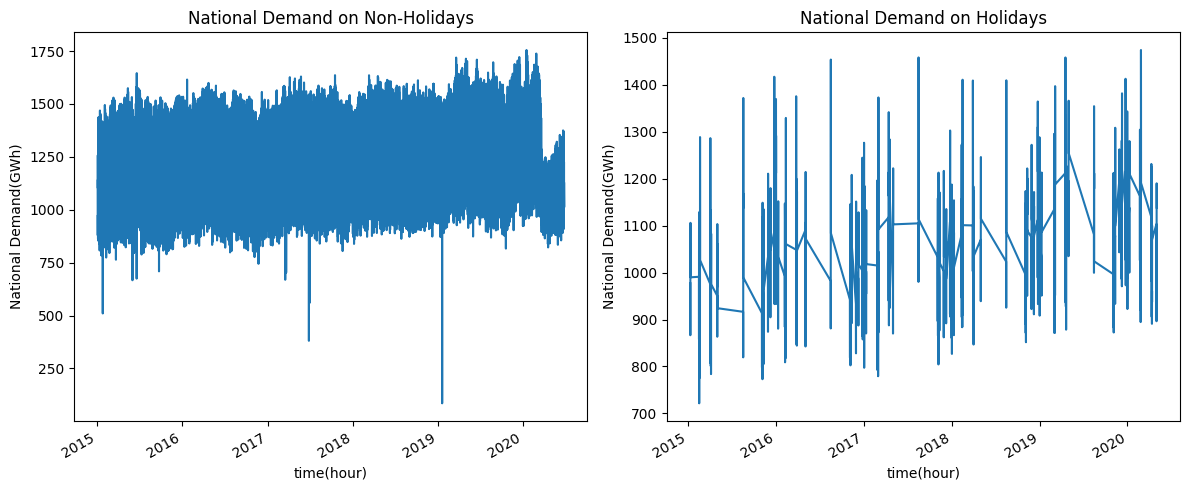

In [19]:
# Create subplots for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot for Holiday_ID != 0 (left)
dfELF[dfELF['Holiday_ID'] == 0]['nat_demand'].plot(ax=axes[0])
axes[0].set_xlabel('time(hour)')
axes[0].set_ylabel('National Demand(GWh)')
axes[0].set_title('National Demand on Non-Holidays')

# Plot for Holiday_ID == 0 (right)
dfELF[dfELF['Holiday_ID'] != 0]['nat_demand'].plot(ax=axes[1])
axes[1].set_xlabel('time(hour)')
axes[1].set_ylabel('National Demand(GWh)')
axes[1].set_title('National Demand on Holidays')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

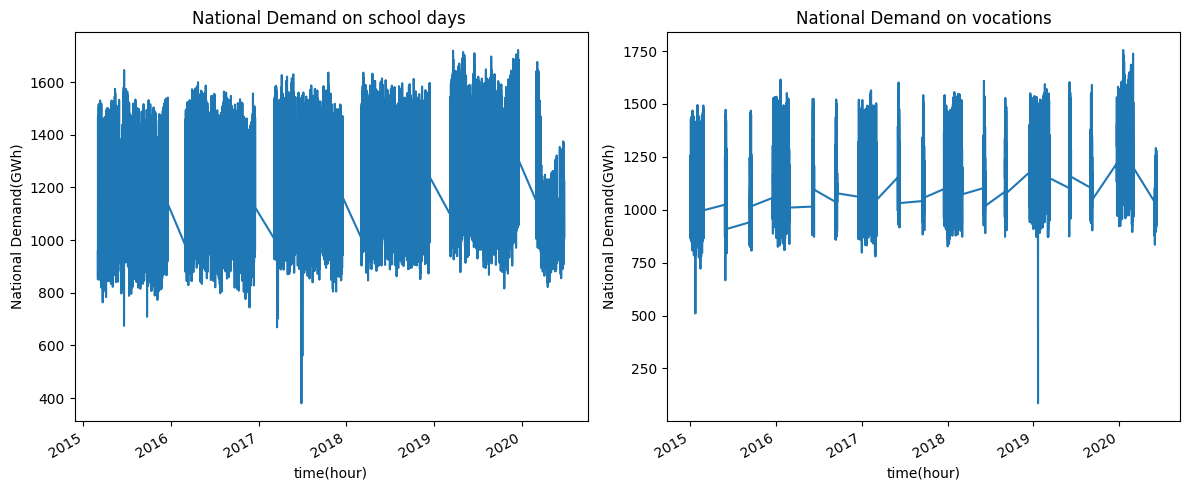

In [20]:
# Create subplots for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot for school == 1 (left)
dfELF[dfELF['school'] == 1]['nat_demand'].plot(ax=axes[0])
axes[0].set_xlabel('time(hour)')
axes[0].set_ylabel('National Demand(GWh)')
axes[0].set_title('National Demand on school days ')

# Plot for school == 0 (right)
dfELF[dfELF['school'] == 0]['nat_demand'].plot(ax=axes[1])
axes[1].set_xlabel('time(hour)')
axes[1].set_ylabel('National Demand(GWh)')
axes[1].set_title('National Demand on vocations')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

* Seasonal Variations: There is a clear seasonal pattern affecting electricity demand, with higher demand during certain periods such as school days and lower demand during vacations.
* Holiday Impact: Holidays introduce significant variability in demand.
* Stable Non-Holiday Demand: There is stable demand on non-holidays .

Because of the Holiday impact, the effect of the spesific holidays analysed.

In [21]:
dfELF['Holiday_ID'].unique()

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22,  1])

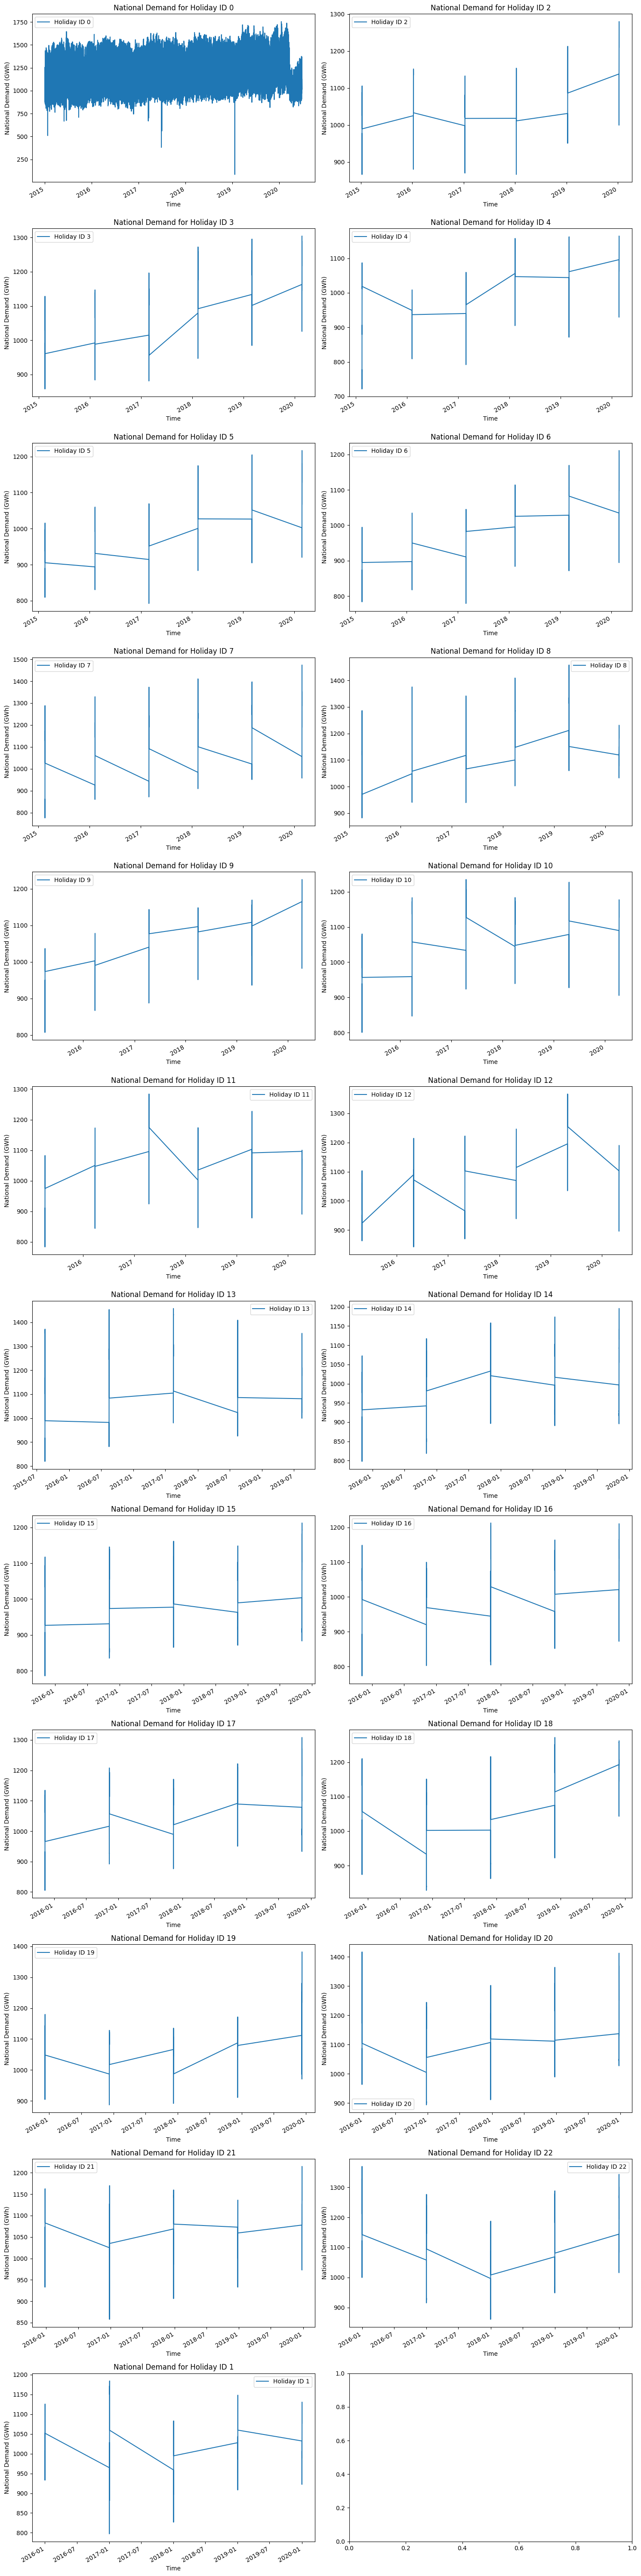

In [22]:
import matplotlib.pyplot as plt

# Get unique holiday IDs
unique_holiday_ids = dfELF['Holiday_ID'].unique()

# Calculate the number of rows and columns for subplots
num_cols = 2  # Adjust as needed
num_rows = (len(unique_holiday_ids) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate through unique holiday IDs and plot on subplots
for i, holiday_id in enumerate(unique_holiday_ids):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    # Filter data for the current holiday ID
    holiday_data = dfELF[dfELF['Holiday_ID'] == holiday_id]['nat_demand']

    # Plot the national demand for the current holiday
    holiday_data.plot(ax=ax, label=f'Holiday ID {holiday_id}')
    ax.set_title(f'National Demand for Holiday ID {holiday_id}')
    ax.set_xlabel('Time')
    ax.set_ylabel('National Demand (GWh)')
    ax.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

Insights:
* Most stable holidays: 6, 7, 9, 14
* Most variabilty holidays: 4, 8, 10, 11, 16, 17, 21
* While demand prediction for stable holidays is easier, for holidays having variability, demand prediction become harder.


## Pie chart

In [23]:

def pie_chart(start, end, df):
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()

    absolute_aggregated_data.drop(['nat_demand'], inplace=True)
    # Plotting the pie chart
    # absolute_aggregated_data.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), title='Energy Distribution for the Selected Period')

    # Explode smaller slices to make them more visible and separate labels
    explode_values = [0.1 if value < 1e6 else 0 for value in absolute_aggregated_data]

    # Plotting the adjusted pie chart
    plt.figure(figsize=(12, 12))  # Increased figure size for better clarity
    absolute_aggregated_data.plot(kind='pie', autopct='%1.1f%%',
                                  title='Dist',
                                  explode=explode_values)

# Filter data for a specific time period (update this to your desired dates)


### Pie Chart Year 2018

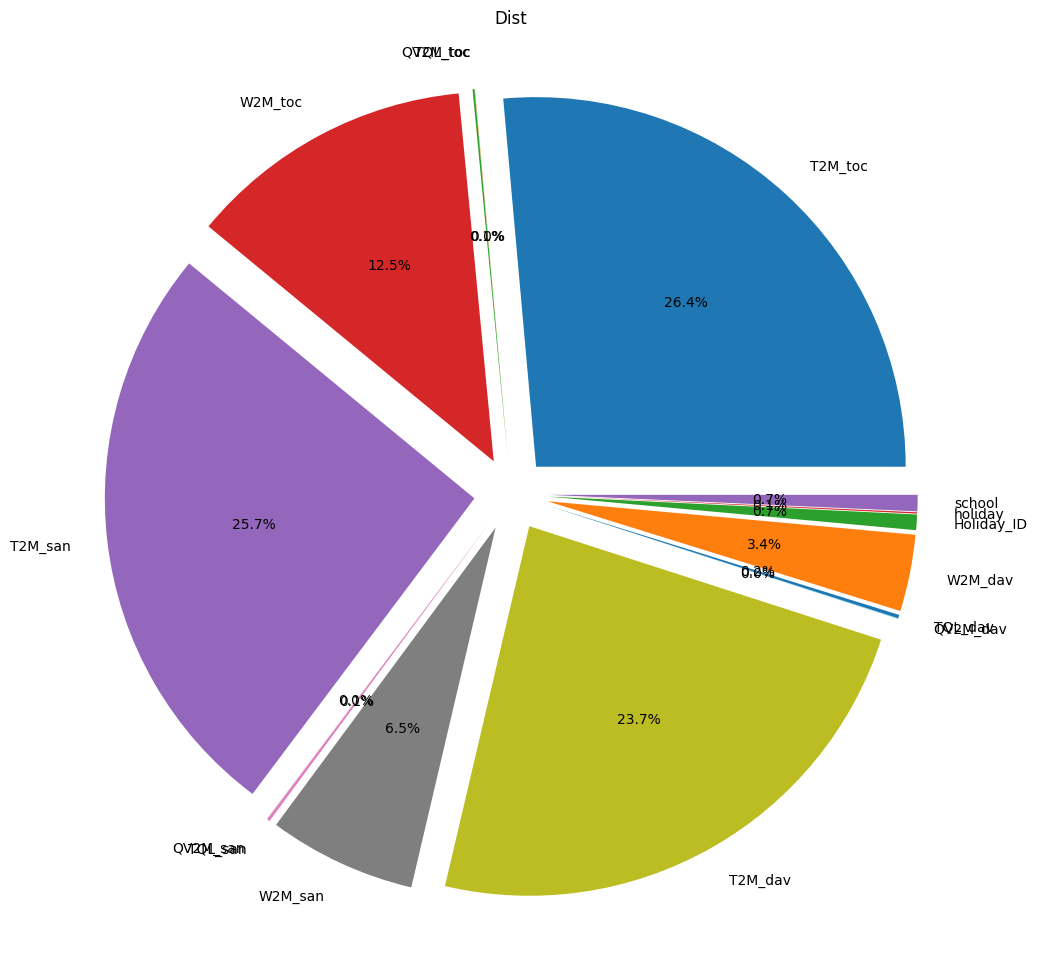

In [24]:
start_date = '2018-01-01'
end_date = '2019-01-01'
pie_chart(start_date, end_date, dfELF)
plt.show()

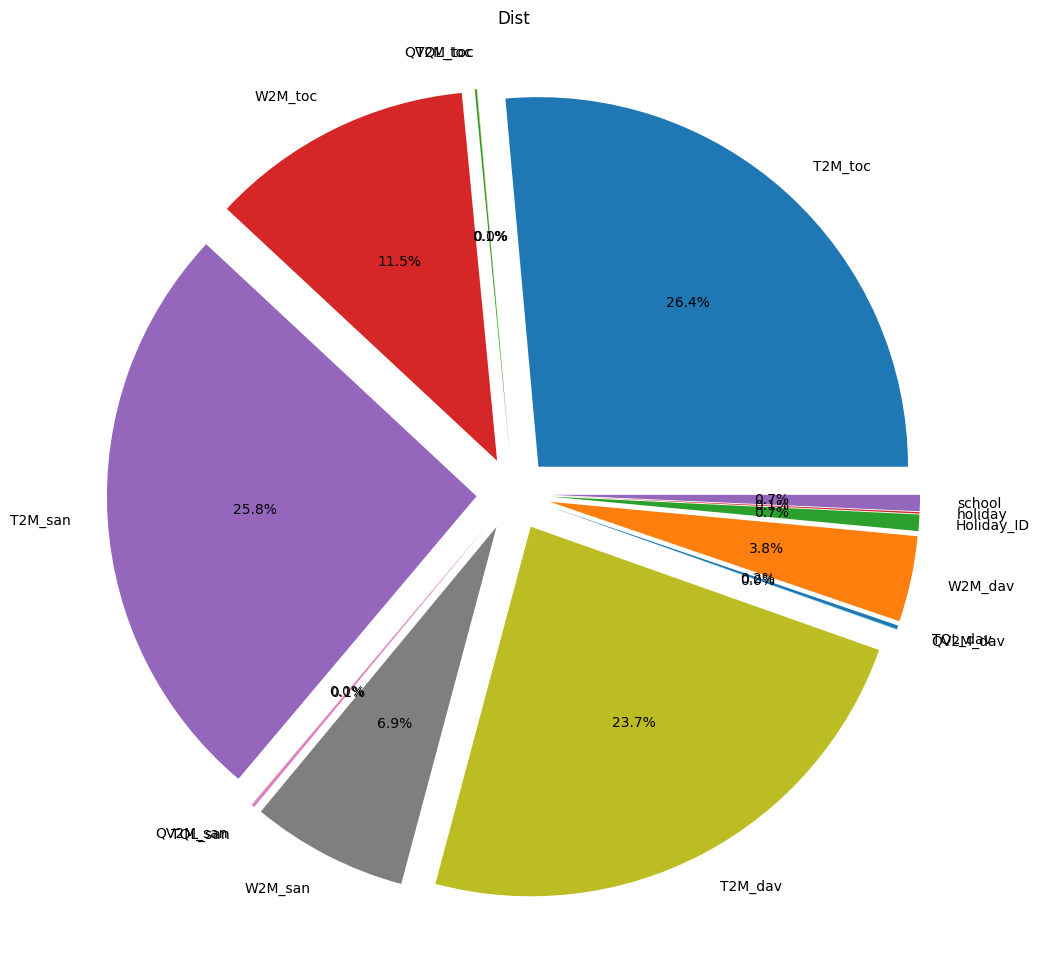

In [25]:
start_date = '2017-01-01'
end_date = '2018-01-01'
pie_chart(start_date, end_date, dfELF)
plt.show()

#Bar Chart

In [26]:
def Tbar_chart(start_date, end_date, df, ax=None):
    # Create a mask for the selected date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()
    absolute_aggregated_data = absolute_aggregated_data[['T2M_toc', 'T2M_san', 'T2M_dav']]

  # Plotting the bar chart using the provided axes object
    if ax is None:  # Handle the case where no axes object is provided
        fig, ax = plt.subplots(figsize=(10, 6))

    absolute_aggregated_data.plot(kind='bar', color='skyblue', edgecolor='black',ax=ax)

    ax.set_title('Distribution')  # Add title
    ax.set_xlabel('Parameter Types')  # Add x-label
    ax.set_ylabel('Value')  # Add y-label
    ax.tick_params(axis='x', rotation=45)



In [27]:
def Wbar_chart(start_date, end_date, df, ax=None):
    # Create a mask for the selected date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()
    absolute_aggregated_data = absolute_aggregated_data[['W2M_toc', 'W2M_san', 'W2M_dav']]

     # Plotting the bar chart using the provided axes object
    if ax is None:  # Handle the case where no axes object is provided
        fig, ax = plt.subplots(figsize=(10, 6))

    absolute_aggregated_data.plot(kind='bar', color='skyblue', edgecolor='black',ax=ax)

    ax.set_title('Distribution')  # Add title
    ax.set_xlabel('Parameter Types')  # Add x-label
    ax.set_ylabel('Value')  # Add y-label
    ax.tick_params(axis='x', rotation=45)



In [28]:
def Lbar_chart(start_date, end_date, df, ax=None):
    # Create a mask for the selected date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()
    absolute_aggregated_data = absolute_aggregated_data[['TQL_toc', 'TQL_san', 'TQL_dav']]
    # Plotting the bar chart using the provided axes object
    if ax is None:  # Handle the case where no axes object is provided
        fig, ax = plt.subplots(figsize=(10, 6))

    absolute_aggregated_data.plot(kind='bar', color='skyblue', edgecolor='black',ax=ax)

    ax.set_title('Distribution')  # Add title
    ax.set_xlabel('Parameter Types')  # Add x-label
    ax.set_ylabel('Value')  # Add y-label
    ax.tick_params(axis='x', rotation=45)



In [29]:
def Qbar_chart(start_date, end_date, df, ax=None):

    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()

    absolute_aggregated_data = aggregated_data.abs()
    absolute_aggregated_data = absolute_aggregated_data[['QV2M_toc', 'QV2M_san', 'QV2M_dav']]


    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    absolute_aggregated_data.plot(kind='bar', color='skyblue', edgecolor='black',ax=ax)

    ax.set_title('Distribution')  # Add title
    ax.set_xlabel('Parameter Types')  # Add x-label
    ax.set_ylabel('Value')  # Add y-label
    ax.tick_params(axis='x', rotation=45)



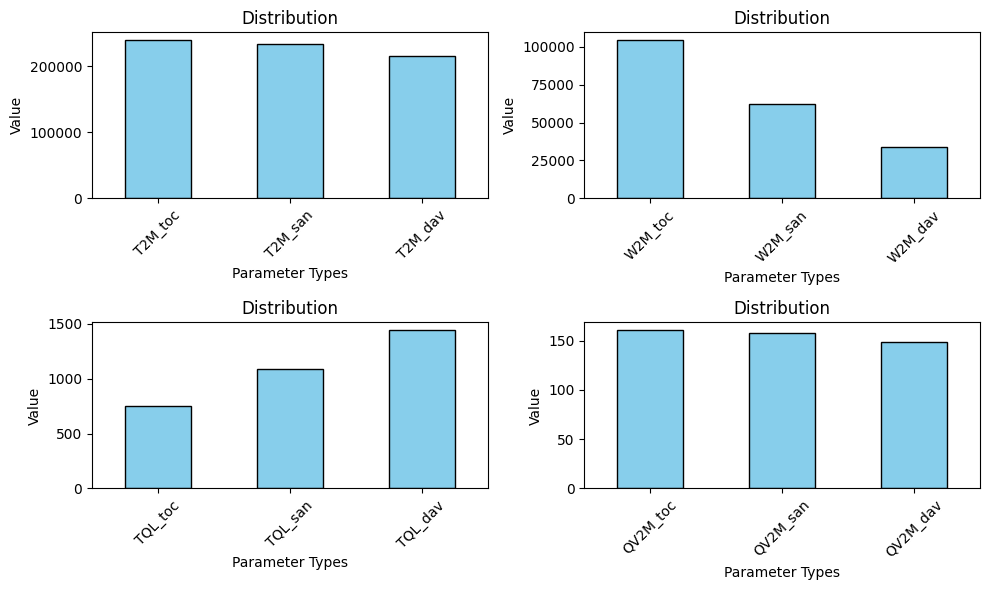

In [30]:

fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2x2 grid of plots

Tbar_chart(start_date, end_date, dfELF, ax=axes[0, 0])
Wbar_chart(start_date, end_date, dfELF, ax=axes[0, 1])
Lbar_chart(start_date, end_date, dfELF, ax=axes[1, 0])
Qbar_chart(start_date, end_date, dfELF, ax=axes[1, 1])

# Adjust layout and display
plt.tight_layout()
plt.show()

Because of the differences in measurement units, bar charts are seperately analyzed.

In [31]:
def multi_year_bar_chart(years, df):
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    # Adjust the width of the bars and the spacing between them
    bar_width = 0.2
    spacing = 0.05
    total_width = bar_width * len(years) + spacing * (len(years) - 1)

    # Colors for different years
    colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple', 'crimson', 'deepskyblue', 'gold', 'mediumorchid']


    for i, year in enumerate(years):
        # Creating a mask for each year
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        mask = (df.index >= start_date) & (df.index <= end_date)
        filtered_df = df.loc[mask]

        # Aggregate and process the data
        aggregated_data = filtered_df.sum()
        absolute_aggregated_data = aggregated_data.abs()
        absolute_aggregated_data.drop(['nat_demand', 'holiday', 'Holiday_ID'], inplace=True)

        # Calculate the offset for each bar
        offset = (np.arange(len(absolute_aggregated_data)) * total_width) + (i * bar_width)

        # Plotting the bars for each year
        plt.bar(x=offset,
                height=absolute_aggregated_data,
                width=bar_width,
                color=colors[i % len(colors)],
                edgecolor='black',
                label=f'{year}')

    # Adjust the x-ticks to be in the center of the group of bars
    plt.xticks(ticks=np.arange(len(absolute_aggregated_data)) * total_width + bar_width,
               labels=absolute_aggregated_data.index,
               rotation=45)

    plt.title(' Distribution by Year')
    plt.xlabel('Parameter types')
    plt.ylabel('Value')
    plt.legend(title='Year')
    plt.show()

# Sample call to the function with the DataFrame
# Replace this with your actual DataFrame
# multi_year_bar_chart([2017, 2018, 2019], df)

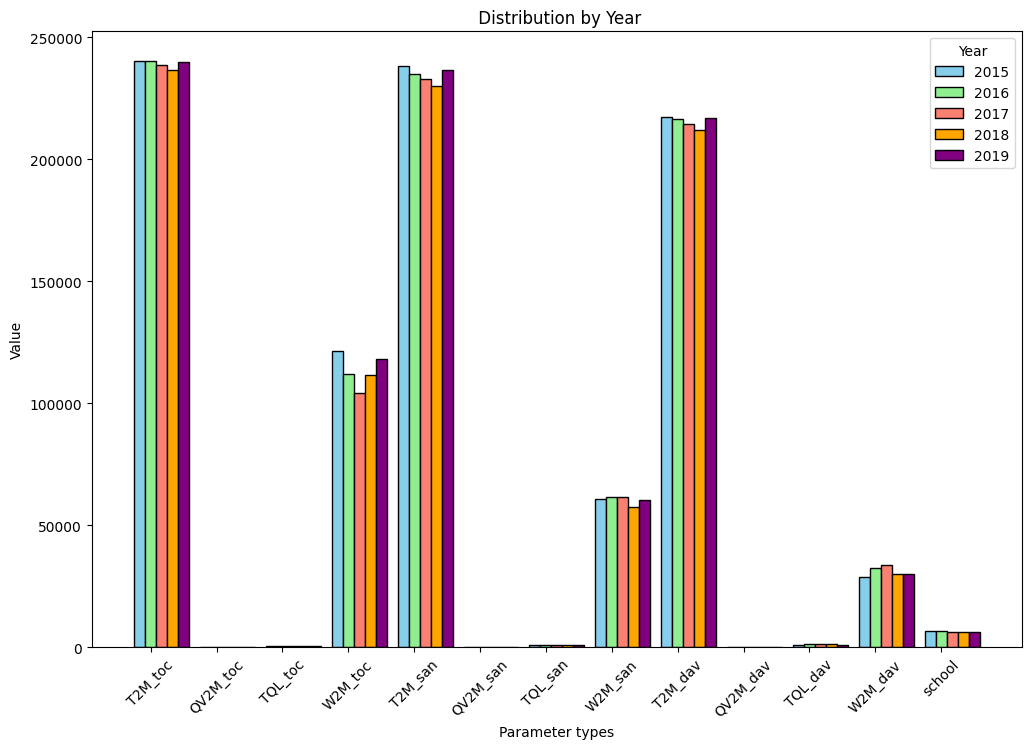

In [32]:
multi_year_bar_chart(range(2015, 2020), dfELF)

There is no sufficient change based on year.

# Modeling:
### Augmented Dickey-Fuller Test


In [33]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [34]:
adf_test(dfELF['nat_demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -20.961750
p-value                     0.000000
# lags used                57.000000
# observations          47990.000000
critical value (1%)        -3.430486
critical value (5%)        -2.861600
critical value (10%)       -2.566802
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**Augmented Dickey-Fuller Test Results**

Based on these test results, the following conclusions can be drawn:

- Since the ADF test statistic is lower than the critical values, and the p-value is significantly lower than the chosen alpha levels, there is strong evidence against the null hypothesis.

- The null hypothesis is rejected.

- The data exhibits no unit root and is considered stationary.

These findings suggest that the time series data under examination is stationary and does not possess a unit root, which is a crucial characteristic for various time series analysis and modeling techniques.



### Data Splitting into Training and Testing Sets


In [35]:
# Printing the maximum timestamp in the dataset
print(dfELF.index.max())

# Printing the minimum timestamp in the dataset
print(dfELF.index.min())


2020-06-27 00:00:00
2015-01-03 01:00:00


Selecting the following date as the dividing point between training and testing data:

In [36]:
dfELF.index = dfELF.index.tz_localize('UTC')
dev_date_str = '2017-12-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')
train_data = dfELF[:dev_date]
test_data = dfELF[dev_date:]

## First Model: Exponential Smoothing
### Model Evaluation: Performance Assessment on Test Set

In [37]:
fitted_model = ExponentialSmoothing(train_data['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Model Evaluation on Test Dataset

In [38]:
# Set the number of days for which the prediction is to be made
number_of_days = 120

# Calculate the total number of hours to predict based on the number of days
number_of_hours_to_predict = number_of_days * 24

# Calculate the end date for the prediction by adding the total hours to the development date (dev_date)
end_date = dev_date + timedelta(hours=number_of_hours_to_predict - 1)

# Extract the actual Gross Consumption data from the test dataset for the specified period
y = test_data['nat_demand'][dev_date:end_date]

# Use the fitted model to forecast the values for the specified number of hours and rename the output series to 'HW_Forecast'
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')


To understand the model's effectiveness and reliability in forecasting over the specified time frame, model evaluation made.

### Visual Comparison of Train, Test, and Predicted Values
The following code snippet is designed to visually compare the National electricity load values across the training data, test data, and the model's predictions:

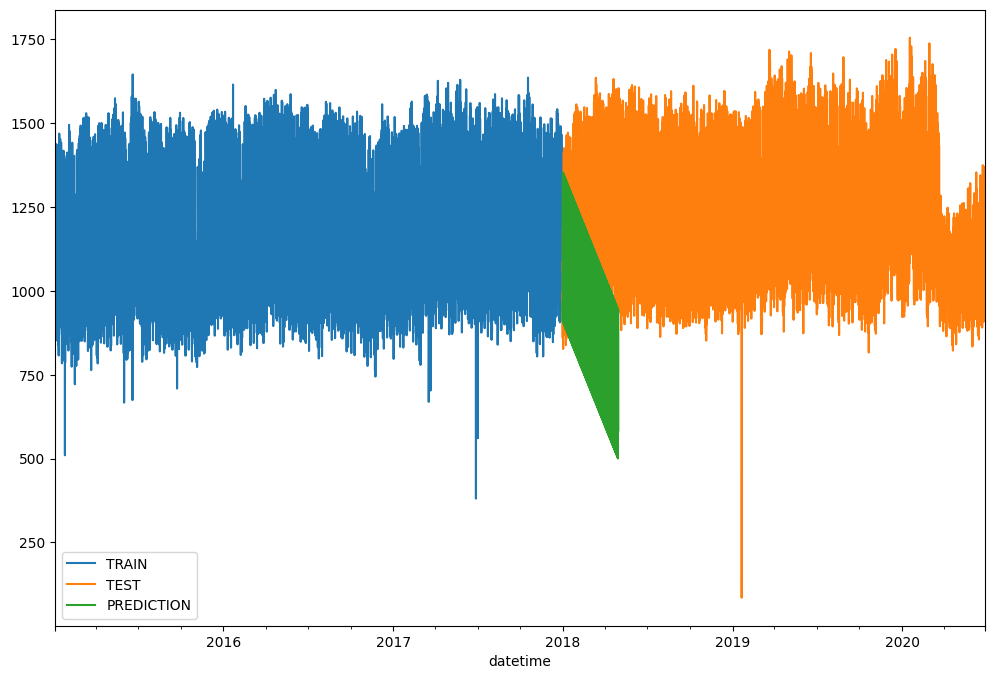

In [39]:
# Plotting the Gross Consumption from the training data
train_data['nat_demand'].plot(legend=True, label='TRAIN')

# Plotting the Gross Consumption from the test data
test_data['nat_demand'].plot(legend=True, label='TEST', figsize=(12,8))

# Plotting the predicted Gross Consumption values
test_predictions.plot(legend=True, label='PREDICTION');


To get a clearer comparison, let's zoom in on the plot:

<Axes: xlabel='datetime'>

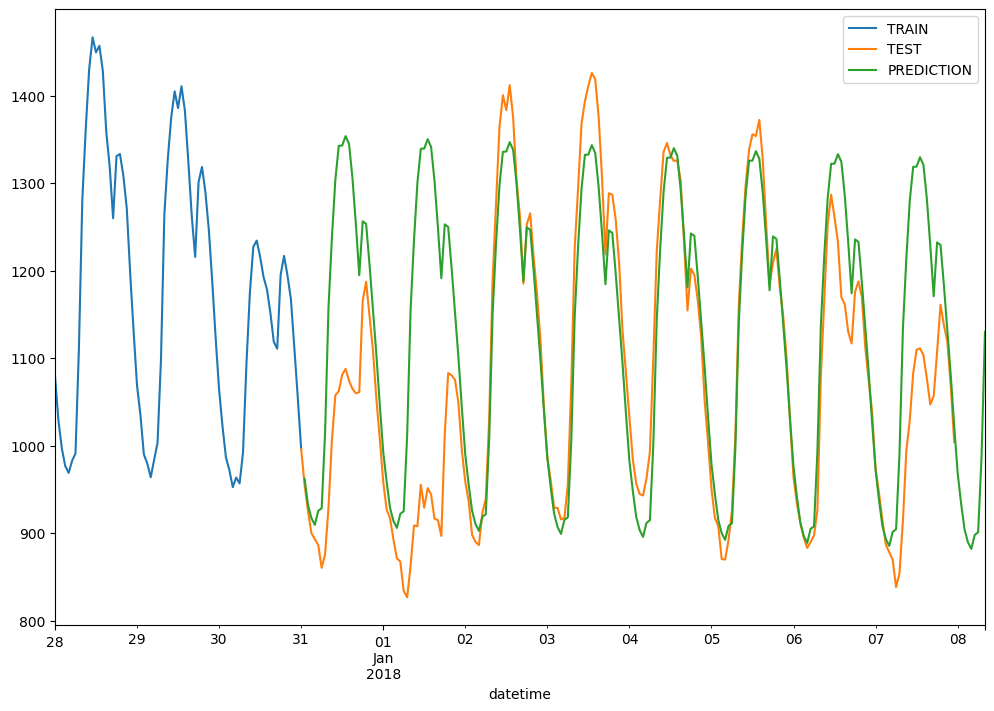

In [40]:
# Plotting the training data
train_data['nat_demand']['2017-12-28':].plot(legend=True, label='TRAIN')

# Plotting the testing data
test_data['nat_demand'][:'2018-01-07'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the predictions (first 200 points)
test_predictions[:200].plot(legend=True, label='PREDICTION')


The results are unsatisfactory because the predicted values show a downward trend.However, They closely resemble the test dataset. Let's assess the results quantitatively.

### Evaluation Metrics


#### Mean Absolute Error (MAE):



In [41]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, test_predictions)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 275.1981285461904


#### Mean Squared Error (MSE):

In [42]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, test_predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 102430.67639839477


#### Root Mean Squared Error (RMSE):



In [43]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 320.04792828324133


These errors being significant signify that the model is performing poorly. It implies that the model's predictions are not accurately capturing the underlying patterns in the data, and there is room for improvement in the model's predictive capabilities. Further analysis and potentially model refinement may be needed to enhance its performance.

## Forecasting into the Future
### Exponential Smoothing
Although this model exhibited a notably high error, let's assess how it performs in predicting future values.

In [46]:
final_model = ExponentialSmoothing(dfELF['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='datetime'>

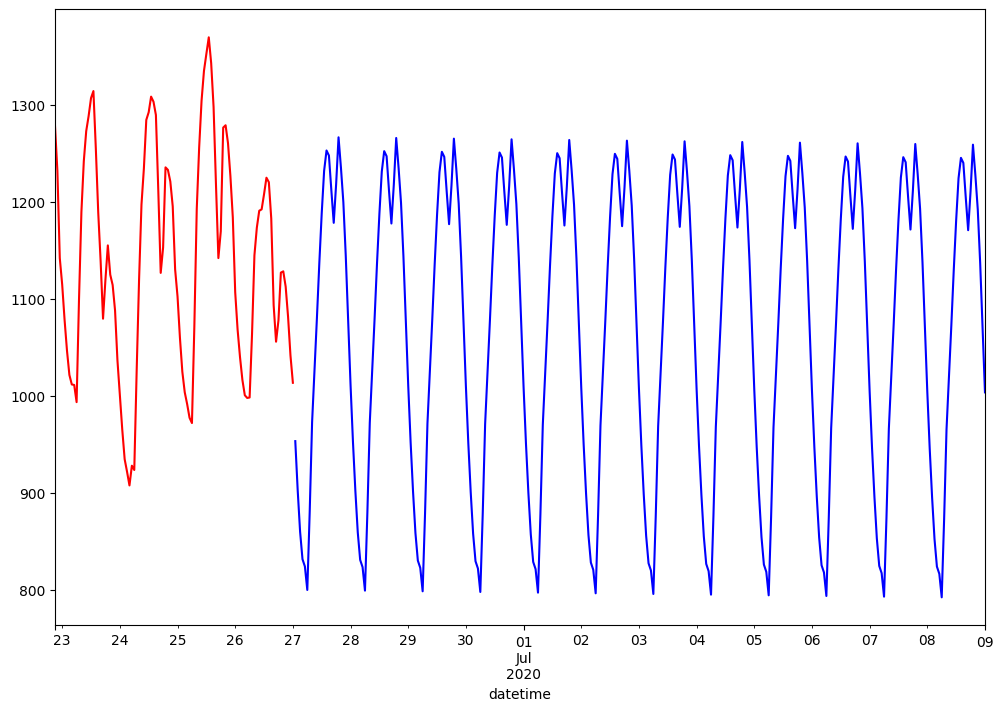

In [47]:
# Setting the number of days for the forecast
day_forecast = 12
hours_forecast = day_forecast * 24

# Generating forecast predictions
forecast_predictions = final_model.forecast(hours_forecast)

# Plotting the last 100 data points in red and the forecast in blue
dfELF['nat_demand'][-100:].plot(figsize=(12, 8), color='red')
forecast_predictions.plot(color='blue')

As anticipated, this model performs inadequately, and the disparity between the actual data and the predicted data is readily apparent upon visual inspection.

## Autoregression (AR) Model




In [48]:
# Importing the Autoregression model from statsmodels library
from statsmodels.tsa.ar_model import AutoReg,ARResults

In [49]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [52]:
model = AutoReg(train_data['nat_demand'], lags=1)

In [53]:
ARfit = model.fit()

In [54]:
ARfit.params

const            58.996727
nat_demand.L1     0.949018
dtype: float64

In [56]:
# This is the general format for obtaining predictions
start=len(train_data['nat_demand'])
end=len(train_data['nat_demand'])+len(test_data['nat_demand'])-1
predictions1 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='datetime'>

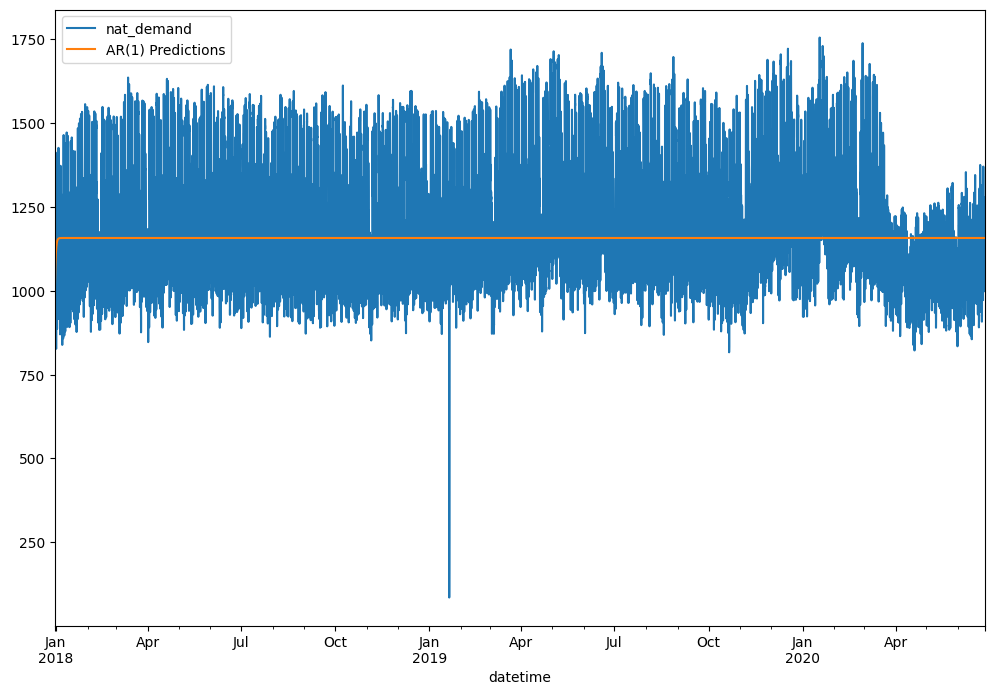

In [57]:
test_data['nat_demand'].plot(figsize=(12, 8), legend=True)
predictions1.plot(figsize=(12, 8), legend=True)

In [58]:


mae = mean_absolute_error(test_data['nat_demand'], predictions1)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 159.92319572435957


In [59]:
mse = mean_squared_error(test_data['nat_demand'], predictions1)
print("Mean Squared Error:", mse)


Mean Squared Error: 38211.641427252376


In [60]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 195.47798195002008


The outcome of this particular model appears to be a flat horizontal line, which indicates that it struggles to capture the fluctuations present in the target variable. Furthermore, the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) all exhibit substantial values, are decreased so model is now performing significantly better than before. It's a good step towards building a robust predictive model.

## Automated ARIMA Model Selection with `pmdarima`



In [61]:
# Importing the `auto_arima` function from `pmdarima` library
!pip install pmdarima
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00


In [62]:
# Using auto_arima to automatically select the best ARIMA model for 'GrossCon' time series data

# Data input: 'GrossCon' time series data (first 1000 data points)
stepwise_fit = auto_arima(dfELF['nat_demand'][:500],

                          # Starting values for ARIMA orders
                          start_p=0,  # Autoregressive order (p)
                          start_q=0,  # Moving average order (q)

                          # Maximum allowable ARIMA orders
                          max_p=3,  # Maximum autoregressive order (p)
                          max_q=3,  # Maximum moving average order (q)

                          # Seasonality information (24-hour seasonality)
                          m=24,  # Number of time steps in a seasonal cycle

                          # Enable seasonal decomposition
                          seasonal=True,

                          # Differencing order (None implies automatic differencing)
                          d=None,

                          # Display progress information during model search
                          trace=True,

                          # Behavior when an order doesn't work (ignore errors)
                          error_action='ignore',

                          # Suppress convergence warnings
                          suppress_warnings=True,

                          # Use the stepwise search approach for efficiency
                          stepwise=True)


stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=6259.356, Time=21.69 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=6621.700, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=17.07 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=5797.247, Time=7.89 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=8434.955, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=6005.168, Time=0.67 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=5797.939, Time=8.72 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=5675.693, Time=22.34 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=5679.311, Time=30.17 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=6242.280, Time=11.98 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=4911.569, Time=19.97 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=5009.431, Time=15.51 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=4726.761, Time=35.13 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=4699.180, Time=12.70 sec
 ARIMA(1,0,1)(1

KeyboardInterrupt: 

ARIMA(1,0,2)(1,0,1)[24] is the best model, which balances fit and complexity

In [63]:
# Import the necessary library
import statsmodels.api as sm

# Create the ARIMA model with the selected parameters
model = sm.tsa.ARIMA(train_data['nat_demand'], order=(1, 0, 2), seasonal_order=(1, 0, 1, 24), enforce_stationarity=False)

# Fit the ARIMA model to the data
model_fit = model.fit()




In [64]:
your_desired_number_of_steps = 24 * 30

# Make future predictions
forecasted_values = model_fit.forecast(steps=your_desired_number_of_steps)

<Axes: xlabel='datetime'>

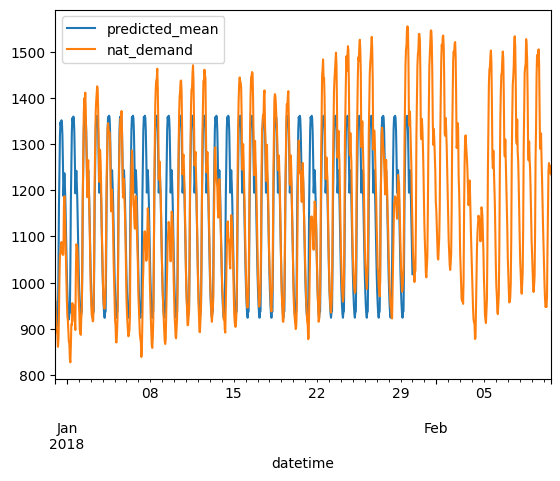

In [65]:
forecasted_values.plot(legend=True)
test_data['nat_demand'][:1000].plot(legend=True)

In [66]:
mae = mean_absolute_error(test_data['nat_demand'][:your_desired_number_of_steps], forecasted_values)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 85.45124779844066


In [67]:
mse = mean_squared_error(test_data['nat_demand'][:your_desired_number_of_steps], forecasted_values)
print("Mean Squared Error:", mse)

Mean Squared Error: 13926.50998488809


In [68]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 118.01063504993137


The results suggest that this model exhibits a high level of error, indicating its inadequacy as an effective predictive model.

## Seasonal Autoregressive Integrated Moving Average (SARIMA) Model



### Using the seasonal decomposed data as exogenic parameter in SARIMA.

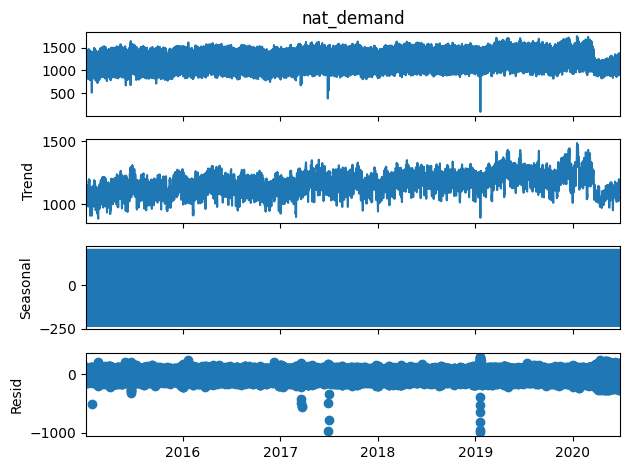

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dfELF['nat_demand'], model='additive')  # model='add' also works
result.plot();

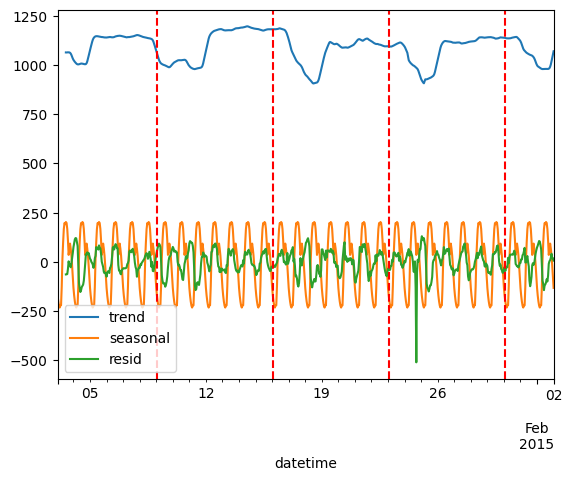

In [71]:
n_days = 30
n = 24 * n_days
# To plot the first n points of the trend component
result.trend[:n].plot(legend=True);

# To plot the first n points of the seasonal component
result.seasonal[:n].plot(legend=True);

# To plot the first n points of the residual component
result.resid[:n].plot(legend=True);

# Adding vertical lines at the start of each week
min_date, max_date = dfELF.index.min(), dfELF.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

<Axes: xlabel='datetime'>

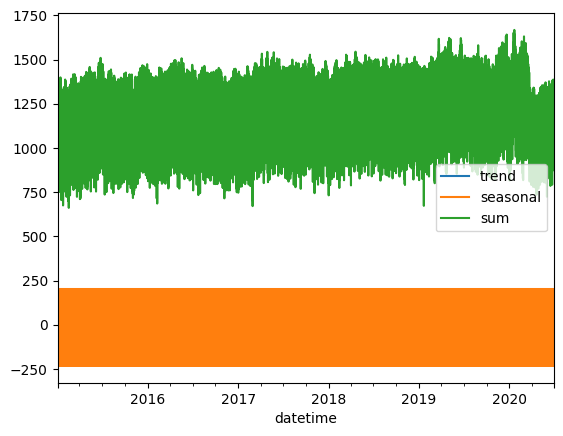

In [72]:
decomp_data = {}
decomp_data['trend'] = result.trend
decomp_data['seasonal'] = result.seasonal
df_decom_data = pd.DataFrame(decomp_data)
df_decom_data['sum'] = df_decom_data['trend'] + df_decom_data['seasonal']
df_decom_data.plot()

In [73]:
df_decom_data.head()

,trend,seasonal,sum
datetime,,,
2015-01-03 01:00:00+00:00,NaN,-171.887459,NaN
2015-01-03 02:00:00+00:00,NaN,-201.678198,NaN
2015-01-03 03:00:00+00:00,NaN,-223.106475,NaN
2015-01-03 04:00:00+00:00,NaN,-232.980741,NaN
2015-01-03 05:00:00+00:00,NaN,-220.058009,NaN


Creating train and test data sets:

In [75]:
dev_date_str = '2017-12-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')
train_data_exo = dfELF[:dev_date]
test_data_exo = dfELF[dev_date:]

df_decom_data_train = df_decom_data[:dev_date]

<Axes: xlabel='datetime'>

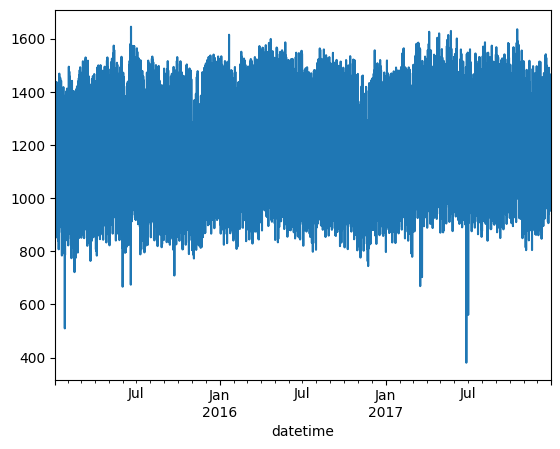

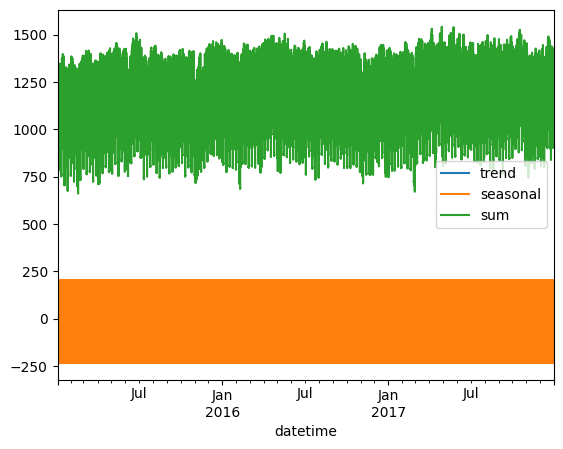

In [76]:
ind = 100000

train_data_exo['nat_demand'][:ind].plot()
df_decom_data_train[:ind].plot()

Fitting the model to the train data set:

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

index = - 200

model = SARIMAX(train_data_exo['nat_demand'][index:],
                exog=df_decom_data_train[index:],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 1, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           nat_demand   No. Observations:                  200
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 24)   Log Likelihood                -894.392
Date:                              Tue, 06 Aug 2024   AIC                           1806.785
Time:                                      17:20:30   BIC                           1836.470
Sample:                                  12-22-2017   HQIC                          1818.798
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.3774      0.028     13.575      0.000       0.323       0.432
seasonal       0.2483      0.039      6.443      0.000       0.173       0.324
sum            0.6258      0.015     42.443      0.000       0.597       0.655
ar.L1          0.8262      0.048     17.038      0.000       0.731       0.921
ma.L1          0.3299      0.067      4.903      0.000       0.198       0.462
ma.L2          0.2722      0.067      4.077      0.000       0.141       0.403
ar.S.L24       0.3414      0.168      2.027      0.043       0.011       0.671
ma.S.L24       0.0837      0.202      0.413      0.679      -0.313       0.480
sigma2       433.9586     33.806     12.837      0.000     367.701     500.216
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                20.91
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.02
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.83e+18. Standard errors may be unstable.
"""

Preparing the exog_forcast data for prediction purposes:

In [90]:
exog_forecast = exog_forecast.head(n_hours_to_predict)
forecast = exog_forecast.shape[0]
start_hour = train_data_exo.index.max()
n_hours_to_predict = test_data_exo.shape[0]

end_hour = start_hour + pd.Timedelta(hours=forecast)

delt = end_hour - start_hour
# start_hour = test_data_exo.index.min()
# end_hour = test_data_exo.index.max()


# to find the exog_forecast data we go back n years in data and pick the history
n_years_back = 3
start_hour_exo_test = start_hour - pd.DateOffset(years=n_years_back)
exog_forecast = df_decom_data_train[start_hour_exo_test: start_hour_exo_test + delt]

new_end = start_hour + pd.Timedelta(hours=exog_forecast.shape[0])
exog_forecast = exog_forecast.fillna(method='ffill')

Because of the inappropriate shape error, exog_forecast is prepared.

In [93]:
exog_filled = exog_forecast.fillna(0)
exog_filled.isna().any()

trend       False
seasonal    False
sum         False
dtype: bool

In [95]:
predictions = results.predict(start=start_hour,
                              end=new_end,
                              exog=exog_filled).rename('SARIMAX(1, 0, 1)(1, 0, 1, 24) Predictions')

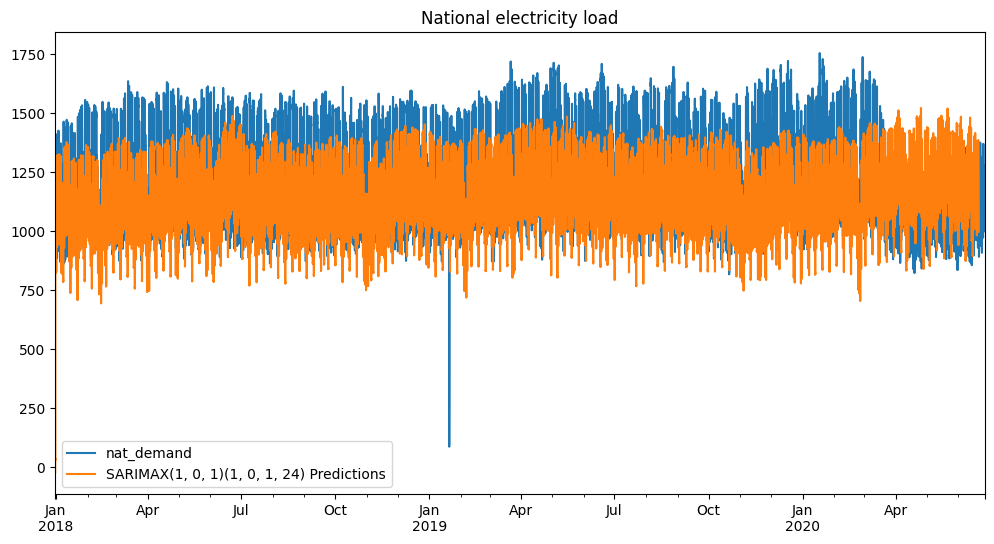

In [96]:
# Plot predictions against known values
title = 'National electricity load'
ylabel=''
xlabel=''

ax = test_data_exo['nat_demand'][:100000].plot(legend=True,figsize=(12,6),title=title)
predictions[:100000].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

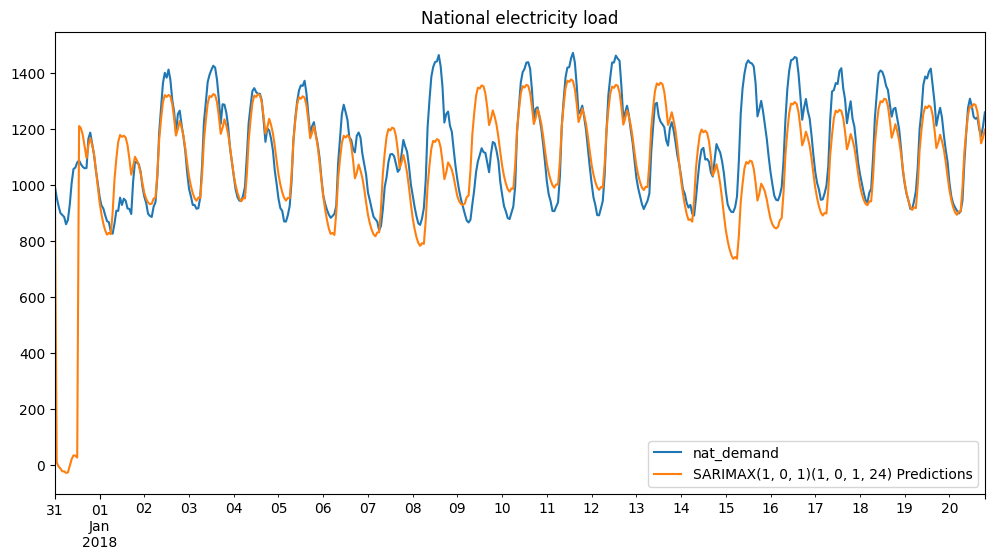

In [97]:
ax = test_data_exo['nat_demand'][:500].plot(legend=True,figsize=(12,6),title=title)

predictions[:500].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [101]:
aligned_nat_demand = test_data_exo['nat_demand'][:len(predictions[:-1])]
mae = mean_absolute_error(aligned_nat_demand, predictions[:-1])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 117.64800083166057


In [103]:
mse = mean_squared_error(aligned_nat_demand, predictions[:-1])
print("Mean Squared Error:", mse)

Mean Squared Error: 23546.61668086739


In [105]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
dfELF.shape

Root Mean Squared Error: 153.44906868686883


(48048, 16)

### Apply on the above method on all of the data:

In [117]:
print(len(dfELF['nat_demand']))


48048


In [132]:

ind_start = 0
ind_end =48048
model = SARIMAX(dfELF['nat_demand'][ind_start:ind_end],
                exog=df_decom_data[ind_start:ind_end],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 1, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           nat_demand   No. Observations:                48048
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 24)   Log Likelihood             -219734.037
Date:                              Tue, 06 Aug 2024   AIC                         439486.074
Time:                                      18:08:42   BIC                         439565.094
Sample:                                  01-03-2015   HQIC                        439510.873
                                       - 06-27-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.9142      0.132      6.938      0.000       0.656       1.172
seasonal       0.9001      0.133      6.782      0.000       0.640       1.160
sum            0.0924      0.132      0.702      0.483      -0.166       0.351
ar.L1          0.7976      0.002    382.733      0.000       0.794       0.802
ma.L1          0.4231      0.002    217.546      0.000       0.419       0.427
ma.L2          0.2145      0.002     92.806      0.000       0.210       0.219
ar.S.L24       0.9867      0.001    954.188      0.000       0.985       0.989
ma.S.L24      -0.9288      0.002   -453.689      0.000      -0.933      -0.925
sigma2       549.2929      0.458   1198.525      0.000     548.395     550.191
===================================================================================
Ljung-Box (L1) (Q):                  37.15   Jarque-Bera (JB):          61590728.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -2.03
Prob(H) (two-sided):                  0.00   Kurtosis:                       178.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predicting the future:

In [142]:
start_hour = dfELF.index.max()

# Define the prediction horizon
n_years_to_predict = 0
n_months_to_predict = 1
n_day_to_predict = 29
end_hour = start_hour + pd.DateOffset(years=n_years_to_predict, months=n_months_to_predict, days=n_day_to_predict)

print(start_hour, end_hour)
delt = end_hour - start_hour

print(delt)

print(len(pd.date_range(start_hour, end_hour, freq="H")))
# to find the exog_forecast data we go back n years in data and pick the history
n_years_go_back = 1
start_hour_exo = start_hour - pd.DateOffset(years=n_years_go_back, months=0, days=0, hours=0)
exog_forecast = df_decom_data[start_hour_exo: start_hour_exo + delt + pd.DateOffset(years=0, months=0, days=0, hours=11)]

print(start_hour_exo, start_hour_exo + delt, exog_forecast.shape)


2020-06-27 00:00:00+00:00 2020-08-25 00:00:00+00:00
59 days 00:00:00
1417
2019-06-27 00:00:00+00:00 2019-08-25 00:00:00+00:00 (1428, 3)


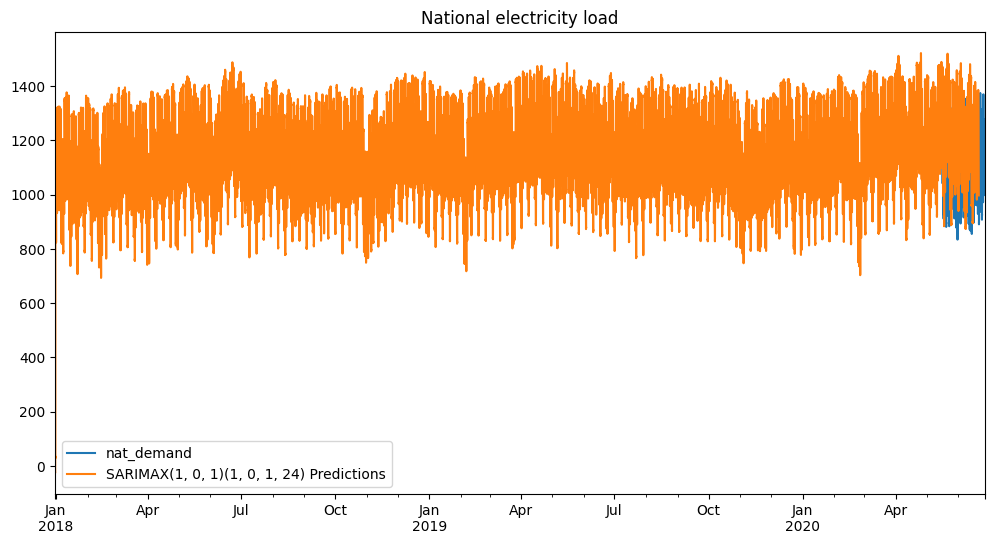

In [143]:
# Plot predictions against known values
title = 'National electricity load'
ylabel=''
xlabel=''

ax = test_data_exo['nat_demand'][-1000:].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#Conclusion

Automated ARIMA Model has best fit and accuracy with:
* Mean Absolute Error: 85.45124779844066
* Mean Squared Error: 13926.50998488809
* Root Mean Squared Error: 118.01063504993137